<a href="https://colab.research.google.com/github/kevinzcyy/DSA4213_Group-25-Project/blob/main/Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [ ]:
import os, re, json, itertools, zipfile, subprocess, shlex, copy
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import random
from pathlib import Path

# Data & Preprocessing
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics import classification_report as sk_classification_report

# Transformers & Training Utilities
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    pipeline,
)

# Evaluation & Metrics
!pip install seqeval
from seqeval.metrics import (
    precision_score as seq_precision,
    recall_score as seq_recall,
    f1_score as seq_f1,
    classification_report as seq_classification_report,
)
import importlib

!pip install evaluate
hf_eval = importlib.import_module("evaluate")
seqeval_metric = hf_eval.load("seqeval")

# Miscellaneous / Environment
import spacy
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=64e4f4f29b16b715a854ff74179740ed6baaa4bb1116757ff88f86349cd180e7
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
save_path = '/content/drive/MyDrive/Group_Project_Results'
os.makedirs(save_path, exist_ok=True)

# Global Seed and Constants

In [ ]:
seed = 25
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

# Directory for outputs
RUN_DIR = "runs"
os.makedirs(RUN_DIR, exist_ok=True)

# FiNER-ORD native labels
ID2LAB_NATIVE = ["O","PER_B","PER_I","LOC_B","LOC_I","ORG_B","ORG_I"]

# Standard BIO labels (for all models)
BIO_LABELS  = [
    "O",
    "B-PER", "I-PER",
    "B-ORG", "I-ORG",
    "B-LOC", "I-LOC",
]
ENT_LABELS = ["O", "PER", "ORG", "LOC"]
LABEL_TO_ID = {lab: i for i, lab in enumerate(BIO_LABELS)}
ID_TO_LABEL = {i: lab for lab, i in LABEL_TO_ID.items()}

# spaCy label harmonization map
HARMONISE = {
    "PERSON": "PER",
    "PER":    "PER",
    "ORG":    "ORG",
    "ORGANIZATION": "ORG",
    "GPE":    "LOC",
    "LOC":    "LOC",
}

CANON = {"PERSON":"PER","PER":"PER","ORG":"ORG","GPE":"LOC","LOC":"LOC"}
def canon(t):
    return HARMONISE.get(t.strip().upper(), t.strip().upper())

VALID_SPACY_TYPES = {"PER", "ORG", "LOC"}

# Core Helper Functions

In [ ]:
def finer_ids_to_bio(id_list):
    """converts FiNER-ORD native ints to standard BIO strings"""
    out = []
    for x in id_list:
        tag = ID2LAB_NATIVE[int(x)]
        if tag.endswith("_B"):
            out.append("B-" + tag[:-2])
        elif tag.endswith("_I"):
            out.append("I-" + tag[:-2])
        else:
            out.append(tag)    # "O"
    return out

_PUNCT_NO_SPACE_BEFORE = {".", ",", ":", ";", "!", "?", "%", ")", "]", "}", "…”", "’", "”", "’s", "'s"}
_PUNCT_NO_SPACE_AFTER  = {"(", "[", "{", "$", "£", "€", "“", "‘"}
_CONTRACTION_PREFIXES  = {"'s","’s","'re","’re","'ve","’ve","'ll","’ll","n't","n’t","'d","’d","'m","’m"}

def detok(tokens):
    """reconstructs a sentence from a list of tokens"""
    out = []
    for tok in tokens:
        if not out:
            out.append(tok); continue
        prev = out[-1]
        if tok in _PUNCT_NO_SPACE_BEFORE or tok in _CONTRACTION_PREFIXES or tok.startswith("'") or tok.startswith("’"):
            out[-1] = prev + tok
        elif prev in _PUNCT_NO_SPACE_AFTER:
            out[-1] = prev + tok
        elif tok in {"-","–"} or prev in {"-","–"}:
            out[-1] = prev + tok
        else:
            out.append(" " + tok)
    return "".join(out)

def _find_token_offsets(tokens, sentence):
    """simple alignment: find each token in order in the original sentence"""
    offsets = []
    pos = 0
    for t in tokens:
        while pos < len(sentence) and sentence[pos].isspace():
            pos += 1
        i = sentence.find(t, pos)
        if i == -1:
            return None
        offsets.append((i, i + len(t)))
        pos = i + len(t)
    return offsets

def offsets_from_sentence(tokens, sentence):
    """Robust token to char alignment."""
    offs = _find_token_offsets(tokens, sentence)
    if offs is not None:
        return offs

    orig = sentence
    norm_chars, map_back = [], []
    i = 0
    while i < len(orig):
        if orig[i].isspace():
            j = i
            while j < len(orig) and orig[j].isspace():
                j += 1
            norm_chars.append(" ")
            map_back.append(i)
            i = j
        else:
            norm_chars.append(orig[i])
            map_back.append(i)
            i += 1
    norm = "".join(norm_chars)

    offs_norm = _find_token_offsets(tokens, norm)
    if offs_norm is None:
        return None

    real_offs = []
    for s, e in offs_norm:
        s0 = map_back[s]
        e0 = map_back[e - 1] + 1
        real_offs.append((s0, e0))
    return real_offs

def build_df_sent(df_finer_raw):
    """converts a raw token-per-row DataFrame to a sentence-per-row DataFrame"""
    df = (
        df_finer_raw
        .groupby(["doc_idx", "sent_idx"])
        .agg({"gold_token": list, "gold_label": list})
        .reset_index(drop=False)
    )
    df["gold_tag"] = df["gold_label"].apply(finer_ids_to_bio)
    df["sentence"] = df["gold_token"].apply(detok)
    offs = []
    for toks, sent in zip(df["gold_token"], df["sentence"]):
        o = offsets_from_sentence(toks, sent)
        if o is None:
            o, pos = [], 0
            for t in toks:
                s, e = pos, pos + len(t)
                o.append((s, e)); pos = e + 1
        offs.append(o)
    df["offsets"] = offs
    return df[["doc_idx","sent_idx","gold_token","gold_label","gold_tag","sentence","offsets"]].copy()

def generate_token_error_report(y_true_bio, y_pred_bio, token_lists, sentence_lists, row_ids):
    """generates a DataFrame of token-level (BIO) errors"""
    rows = []
    row_id_counter = 0

    for i, (gold_seq, pred_seq, toks, sent) in enumerate(
        zip(y_true_bio, y_pred_bio, token_lists, sentence_lists)
    ):
        original_row_id = row_ids[i] # index from df_sent_test

        # Align lengths
        m = min(len(gold_seq), len(pred_seq), len(toks))

        for j in range(m):
            g = gold_seq[j]
            p = pred_seq[j]

            if g != p:
                # Get context
                left_ctx  = " ".join(toks[max(0, j-2):j])
                right_ctx = " ".join(toks[j+1:j+3])

                rows.append({
                    "row_id": row_id_counter,
                    "original_df_index": original_row_id,
                    "token_index": j,
                    "left": left_ctx,
                    "token": toks[j],
                    "right": right_ctx,
                    "gold": g,
                    "pred": p,
                    "sentence": sent
                })
                row_id_counter += 1

    return pd.DataFrame(rows)

## spaCy helpers

In [ ]:
def spacy_spans_to_bio(spans, token_offsets):
    """
    Maps spaCy's character-level spans to word-level BIO tags
    spans: list[(start_char, end_char, label)]
    token_offsets: list[(start_char, end_char)] for each token
    """
    n = len(token_offsets)
    raw_labels = ["O"] * n

    for i, (ts, te) in enumerate(token_offsets):
        best_label, best_ov = "O", 0
        for (s, e, lab) in spans:
            if not lab:  # ignore labels we mapped to ""
                continue
            ov = max(0, min(te, e) - max(ts, s))
            if ov > best_ov:
                best_label, best_ov = lab, ov
        raw_labels[i] = best_label

    bio = []
    prev = "O"
    for lab in raw_labels:
        if lab == "O":
            bio.append("O")
            prev = "O"
        else:
            if prev == lab:
                bio.append("I-" + lab)
            else:
                bio.append("B-" + lab)
            prev = lab
    return bio

## Analysis helpers

In [ ]:
def build_confusion(y_true_flat, y_pred_flat, labels, normalize=None):
    """Builds a confusion matrix from flat lists of labels."""
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    if normalize is True or str(normalize).lower() in {"true","row","rows"}:
        denom = cm.sum(axis=1, keepdims=True)
        cm = cm.astype(float) / np.clip(denom, 1, None)
    return cm

def show_cm(cm, labels, title, save_path=None, value_fmt=".2f"):
    """Displays a confusion matrix"""
    if value_fmt is None:
        value_fmt = ".0f" if np.issubdtype(cm.dtype, np.integer) else ".2f"
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=True, fmt=value_fmt,
                     xticklabels=labels, yticklabels=labels, cmap="viridis")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300)
    plt.show()

def bio_to_spans(tags, tokens):
    """Converts BIO token tags to list of spans (start_idx, end_idx, label, text)"""
    spans, cur_type, start = [], None, None
    for i, tag in enumerate(tags):
        if tag == "O" or tag is None:
            if cur_type is not None:
                spans.append({"type": cur_type, "start": start, "end": i,
                              "text": " ".join(tokens[start:i])})
                cur_type, start = None, None
            continue
        pref, et = tag.split("-", 1)
        et = canon(et)  # <— add this
        if pref == "B":
            if cur_type is not None:
                spans.append({"type": cur_type, "start": start, "end": i,
                              "text": " ".join(tokens[start:i])})
            cur_type, start = et, i
        else:  # I-*
            if cur_type != et:
                if cur_type is not None:
                    spans.append({"type": cur_type, "start": start, "end": i,
                                  "text": " ".join(tokens[start:i])})
                cur_type, start = et, i
    if cur_type is not None:
        spans.append({"type": cur_type, "start": start, "end": len(tags),
                      "text": " ".join(tokens[start:])})
    return spans

def span_iou(a, b):
    """Calculates IoU for two word-index spans {start, end}."""
    inter = max(0, min(a["end"], b["end"]) - max(a["start"], b["start"]))
    if inter == 0: return 0.0
    union = max(a["end"], b["end"]) - min(a["start"], b["start"])
    return inter / union

def get_entity_cm_pairs(true_tag_seqs, pred_tag_seqs, iou_thresh=0.5, add_background=True):
    """
    Build (true_label, pred_label) pairs with IoU-based matching.
    Unmatched gold → (gold_type, 'O'); unmatched pred → ('O', pred_type).
    Optionally add ('O','O') when a sentence has no entities at all.
    """
    pairs = []
    for gold_tags, pred_tags in zip(true_tag_seqs, pred_tag_seqs):
        gold_spans = bio_to_spans_simple(gold_tags)   # [(s,e,TYPE), ...]
        pred_spans = bio_to_spans_simple(pred_tags)

        used_pred = set()
        # 1) greedy best-IoU matching
        for gi, g in enumerate(gold_spans):
            best_pi, best_iou = None, 0.0
            for pi, p in enumerate(pred_spans):
                if pi in used_pred:
                    continue
                iou = span_iou_tuple(g, p)
                if iou > best_iou:
                    best_iou, best_pi = iou, pi
            if best_pi is not None and best_iou >= iou_thresh:
                pairs.append((g[2], pred_spans[best_pi][2]))  # (gold_type, pred_type)
                used_pred.add(best_pi)
            else:
                pairs.append((g[2], "O"))  # FN

        # 2) remaining predictions are FPs
        for pi, p in enumerate(pred_spans):
            if pi not in used_pred:
                pairs.append(("O", p[2]))

        # 3) optional background when no entities at all
        # if add_background and not gold_spans and not pred_spans:
        #     pairs.append(("O", "O"))
    return pairs

def generate_span_error_report(y_true_bio, y_pred_bio, token_lists, row_ids, iou_thresh=0.5):
    """Generates DataFrames for Type Confusions, FNs and FPs."""
    type_err_rows, fn_rows, fp_rows = [], [], []

    for i, (gold_bio, pred_bio, words) in enumerate(zip(y_true_bio, y_pred_bio, token_lists)):
        row_id = row_ids[i]
        gold_spans = bio_to_spans(gold_bio, words)
        pred_spans = bio_to_spans(pred_bio, words)

        gold_used, pred_used, pairs = set(), set(), []
        for gi, g in enumerate(gold_spans):
            best_pi, best_iou = None, 0.0
            for pi, p in enumerate(pred_spans):
                if pi in pred_used: continue
                iou = span_iou(g, p)
                if iou > best_iou:
                    best_iou, best_pi = iou, pi
            if best_pi is not None and best_iou >= iou_thresh:
                pairs.append((gi, best_pi))
                gold_used.add(gi); pred_used.add(best_pi)

        for gi, pi in pairs:
            g, p = gold_spans[gi], pred_spans[pi]
            if g["type"] != p["type"]:
                type_err_rows.append({
                    "row_id": row_id, "gold_type": g["type"], "pred_type": p["type"],
                    "surface_gold": g["text"], "surface_pred": p["text"], "sentence": " ".join(words)
                })

        for gi, g in enumerate(gold_spans):
            if gi not in gold_used:
                fn_rows.append({
                    "row_id": row_id, "type": g["type"], "surface": g["text"], "sentence": " ".join(words)
                })
        for pi, p in enumerate(pred_spans):
            if pi not in pred_used:
                fp_rows.append({
                    "row_id": row_id, "type": p["type"], "surface": p["text"], "sentence": " ".join(words)
                })

    order = ["ORG", "LOC", "PER"]
    df_type_err = pd.DataFrame(type_err_rows)
    if not df_type_err.empty:
        df_type_err = (
            df_type_err
            .assign(
                _g=pd.Categorical(df_type_err["gold_type"], order, ordered=True),
                _p=pd.Categorical(df_type_err["pred_type"], order, ordered=True),
            )
            .sort_values(["_g","_p"])
            .drop(columns=["_g","_p"])
            .reset_index(drop=True)
        )

    df_fn = pd.DataFrame(fn_rows).sort_values(["type"]).reset_index(drop=True)
    df_fp = pd.DataFrame(fp_rows).sort_values(["type"]).reset_index(drop=True)

    return df_type_err, df_fn, df_fp

def native_to_bio(tag: str) -> str:
    # FiNER native: PER_B, ORG_I, LOC_B, O
    if tag.endswith("_B"):
        return "B-" + tag[:-2]   # PER_B -> B-PER
    if tag.endswith("_I"):
        return "I-" + tag[:-2]   # ORG_I -> I-ORG
    return tag                   # O stays O


def bio_to_spans_simple(tags):
    spans, cur_type, start = [], None, None
    for i, tag in enumerate(tags):
        if tag == "O" or tag is None:
            if cur_type is not None:
                spans.append((start, i, cur_type)); cur_type, start = None, None
            continue
        pref, et = tag.split("-", 1)
        et = canon(et)  # <— add this
        if pref == "B":
            if cur_type is not None:
                spans.append((start, i, cur_type))
            cur_type, start = et, i
        else:  # I-*
            if cur_type != et:
                if cur_type is not None:
                    spans.append((start, i, cur_type))
                cur_type, start = et, i
    if cur_type is not None:
        spans.append((start, len(tags), cur_type))
    return spans

def span_iou_tuple(a, b):
    """IoU for two (s,e,_) spans."""
    s1, e1, _ = a; s2, e2, _ = b
    inter = max(0, min(e1, e2) - max(s1, s2))
    if inter == 0: return 0.0
    union = max(e1, e2) - min(s1, s2)
    return inter / union

def bio_to_spans_exact(tags):
    spans, cur_type, start = [], None, None
    for i, raw in enumerate(tags):
        tag = (raw or "O").strip()
        if tag == "O" or "-" not in tag:
            if cur_type is not None:
                spans.append((start, i, cur_type))
                cur_type, start = None, None
            continue
        pref, et = tag.split("-", 1)
        et = canon(et)
        if pref == "B":
            if cur_type is not None:
                spans.append((start, i, cur_type))
            cur_type, start = et, i
        elif pref == "I":
            if cur_type != et:
                if cur_type is not None:
                    spans.append((start, i, cur_type))
                cur_type, start = et, i
        else:  # any stray prefix -> treat as B
            if cur_type is not None:
                spans.append((start, i, cur_type))
            cur_type, start = et, i
    if cur_type is not None:
        spans.append((start, len(tags), cur_type))
    return spans

def pairs_for_confusion(y_true_seqs, y_pred_seqs, add_background=True):
    pairs = []
    for gold_tags, pred_tags in zip(y_true_seqs, y_pred_seqs):
        gold = {(s,e):t for (s,e,t) in bio_to_spans_exact(gold_tags)}
        pred = {(s,e):t for (s,e,t) in bio_to_spans_exact(pred_tags)}
        used = set()
        for span, g_lab in gold.items():
            if span in pred:
                pairs.append((g_lab, pred[span])); used.add(span)
            else:
                pairs.append((g_lab, "O"))
        for span, p_lab in pred.items():
            if span not in used:
                pairs.append(("O", p_lab))
        if add_background and not gold and not pred:
            pairs.append(("O","O"))
    return pairs

# def pairs_for_confusion_exact(y_true_seqs, y_pred_seqs, add_background=True):
#     pairs = []
#     for gold_tags, pred_tags in zip(y_true_seqs, y_pred_seqs):
#         gold = {(s,e):t for (s,e,t) in bio_to_spans_simple(gold_tags)}
#         pred = {(s,e):t for (s,e,t) in bio_to_spans_simple(pred_tags)}
#         used = set()
#         for span, g_lab in gold.items():
#             if span in pred:
#                 pairs.append((g_lab, pred[span])); used.add(span)
#             else:
#                 pairs.append((g_lab, "O"))
#         for span, p_lab in pred.items():
#             if span not in used:
#                 pairs.append(("O", p_lab))
#         if add_background and not gold and not pred:
#             pairs.append(("O","O"))
#     return pairs


# Data Loading and Preprocessing

In [ ]:
# loading datasets
ds_fiqa = load_dataset("TheFinAI/fiqa-sentiment-classification")
ds_finer = load_dataset("gtfintechlab/finer-ord")

# FiQA (Sentiment)
df_fiqa = ds_fiqa["train"].to_pandas()
print(f"FiQA data shape: {df_fiqa.shape}")

# FiNER (NER)
# convert token-per-row to pandas DataFrames
df_finer_train = ds_finer["train"].to_pandas().dropna(subset=["gold_token"])
df_finer_val   = ds_finer["validation"].to_pandas().dropna(subset=["gold_token"])
df_finer_test  = ds_finer["test"].to_pandas().dropna(subset=["gold_token"])

print("Raw FiNER token-per-row shapes:", {
    "train": df_finer_train.shape,
    "validation": df_finer_val.shape,
    "test": df_finer_test.shape
})

# convert to sentence-per-row DataFrames
print("\nBuilding sentence-level DataFrames...")
df_sent_train = build_df_sent(df_finer_train)
df_sent_val   = build_df_sent(df_finer_val)
df_sent_test  = build_df_sent(df_finer_test)

print("Sentence-level FiNER shapes:", {
    "train": df_sent_train.shape,
    "validation": df_sent_val.shape,
    "test": df_sent_test.shape
})

# create the final Hugging Face DatasetDict (for FinBERT)
# use the sentence-per-row DataFrames just built
ds_sent = DatasetDict({
    "train":      Dataset.from_pandas(df_sent_train, preserve_index=False),
    "validation": Dataset.from_pandas(df_sent_val, preserve_index=False),
    "test":       Dataset.from_pandas(df_sent_test, preserve_index=False),
})

print("\nCreated DatasetDict 'ds_sent':")
print(ds_sent)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-aeefa1eadf5be1(…):   0%|          | 0.00/61.8k [00:00<?, ?B/s]

data/test-00000-of-00001-0fb9f3a47c7d0fc(…):   0%|          | 0.00/26.8k [00:00<?, ?B/s]

data/valid-00000-of-00001-51867fe1ac59af(…):   0%|          | 0.00/13.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/234 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/117 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/80531 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10233 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25957 [00:00<?, ? examples/s]

FiQA data shape: (822, 6)
Raw FiNER token-per-row shapes: {'train': (80530, 4), 'validation': (10233, 4), 'test': (25957, 4)}

Building sentence-level DataFrames...
Sentence-level FiNER shapes: {'train': (3262, 7), 'validation': (402, 7), 'test': (1075, 7)}

Created DatasetDict 'ds_sent':
DatasetDict({
    train: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 3262
    })
    validation: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 402
    })
    test: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 1075
    })
})


# NER with FiNER-ORD


## Baseline Model 1: spaCy

In [ ]:
def eval_spacy(df_split):
    """runs spaCy NER on a sentence-level DataFrame and returns BIO tags"""
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","attribute_ruler","lemmatizer"])
    y_true, y_pred = [], []

    print(f"Running spaCy on {len(df_split)} sentences...")
    for row in tqdm(df_split.itertuples(index=False), total=len(df_split)):
        doc = nlp(row.sentence)
        spans = [(ent.start_char, ent.end_char, HARMONISE.get(ent.label_, "")) for ent in doc.ents]
        pred_bio = spacy_spans_to_bio(spans, row.offsets)

        # align lengths
        m = min(len(pred_bio), len(row.gold_tag))
        y_true.append(row.gold_tag[:m])
        y_pred.append(pred_bio[:m])

    return y_true, y_pred

# run predictions, Validation
spacy_true_val, spacy_pred_val = eval_spacy(df_sent_val)
print("\n====== spaCy on VALIDATION ======")
print(seq_classification_report(spacy_true_val, spacy_pred_val, digits=4))
spacy_f1_val = seq_f1(spacy_true_val, spacy_pred_val)

# run predictions, Test
# run this ONCE and save the results for all analysis
spacy_true_test, spacy_pred_test = eval_spacy(df_sent_test)
print("\n====== spaCy on TEST ======")
print(seq_classification_report(spacy_true_test, spacy_pred_test, digits=4))
spacy_p = seq_precision(spacy_true_test, spacy_pred_test)
spacy_r = seq_recall(spacy_true_test, spacy_pred_test)
spacy_f = seq_f1(spacy_true_test, spacy_pred_test)
print(f"""spaCy (Test):
Precision: {spacy_p:.4f}
Recall:    {spacy_r:.4f}
F1:        {spacy_f:.4f}""")

Running spaCy on 402 sentences...


100%|██████████| 402/402 [00:09<00:00, 40.60it/s]



====== spaCy on VALIDATION ======
              precision    recall  f1-score   support

         LOC     0.7845    0.7358    0.7594       193
         ORG     0.5154    0.4209    0.4634       278
         PER     0.6429    0.7826    0.7059       138

   micro avg     0.6372    0.6026    0.6194       609
   macro avg     0.6476    0.6464    0.6429       609
weighted avg     0.6296    0.6026    0.6121       609

Running spaCy on 1075 sentences...


100%|██████████| 1075/1075 [00:14<00:00, 72.67it/s]



====== spaCy on TEST ======
              precision    recall  f1-score   support

         LOC     0.6655    0.6300    0.6473       300
         ORG     0.4678    0.4991    0.4829       553
         PER     0.6944    0.6993    0.6969       286

   micro avg     0.5723    0.5838    0.5780      1139
   macro avg     0.6092    0.6095    0.6090      1139
weighted avg     0.5768    0.5838    0.5799      1139

spaCy (Test):
Precision: 0.5723
Recall:    0.5838
F1:        0.5780


### confusion Matrices (on Test set)

spaCy Test Classification Report:
              precision    recall  f1-score   support

           O     0.5423    0.5276    0.5348       851
         PER     0.6944    0.6993    0.6969       286
         ORG     0.4678    0.4991    0.4829       553
         LOC     0.6655    0.6300    0.6473       300

    accuracy                         0.5598      1990
   macro avg     0.5925    0.5890    0.5905      1990
weighted avg     0.5620    0.5598    0.5607      1990



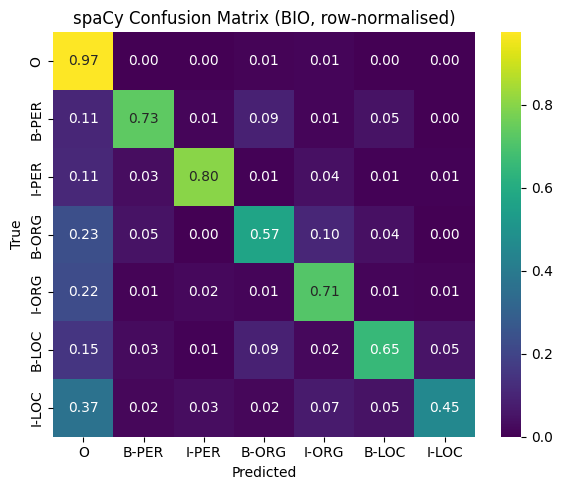

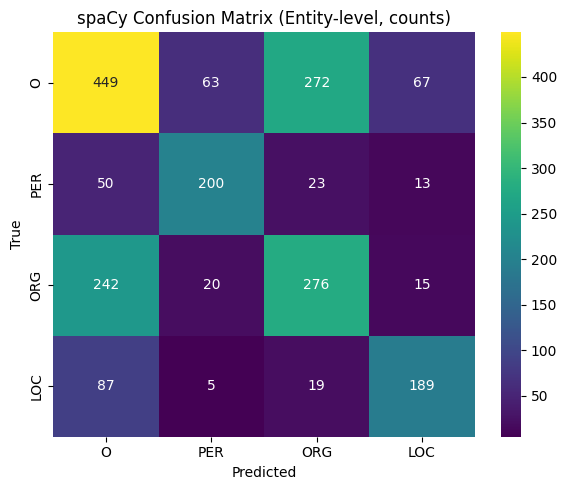

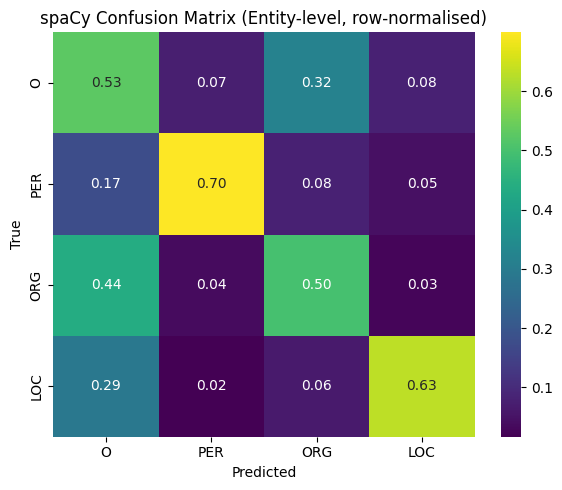

In [ ]:
# ent_pairs_spacy = get_entity_cm_pairs(spacy_true_test, spacy_pred_test)
ent_pairs_spacy = pairs_for_confusion(spacy_true_test, spacy_pred_test, add_background=True)
ent_true_spacy = [a for (a, _) in ent_pairs_spacy]
ent_pred_spacy = [b for (_, b) in ent_pairs_spacy]
print("spaCy Test Classification Report:")
print(sk_classification_report(ent_true_spacy, ent_pred_spacy, labels=ENT_LABELS, digits=4))


# BIO-level, row-normalised
# use the saved predictions
bio_true_flat = [t for seq in spacy_true_test for t in seq]
bio_pred_flat = [p for seq in spacy_pred_test for p in seq]
cm_bio_spacy = build_confusion(bio_true_flat, bio_pred_flat, BIO_LABELS, normalize="true")
show_cm(
    cm_bio_spacy,
    BIO_LABELS,
    "spaCy Confusion Matrix (BIO, row-normalised)",
    os.path.join(RUN_DIR, "spacy_cm_bio.png"),
)

# Entity-level, counts
cm_ent_spacy = build_confusion(ent_true_spacy, ent_pred_spacy, ENT_LABELS, normalize=None)
show_cm(
    cm_ent_spacy,
    ENT_LABELS,
    "spaCy Confusion Matrix (Entity-level, counts)",
    os.path.join(RUN_DIR, "spacy_cm_entity_counts.png"),
    value_fmt=".0f",
)

# Entity-level, row-normalised
cm_ent_norm_spacy = build_confusion(ent_true_spacy, ent_pred_spacy, ENT_LABELS, normalize="true")
show_cm(
    cm_ent_norm_spacy,
    ENT_LABELS,
    "spaCy Confusion Matrix (Entity-level, row-normalised)",
    os.path.join(RUN_DIR, "spacy_cm_entity_norm.png"),
)

### Misclassified Examples (on Test Set)

In [ ]:
# use the saved predictions and the refactored error report function
print("spaCy span-level error reports:")
df_spacy_type, df_spacy_fn, df_spacy_fp = generate_span_error_report(
    spacy_true_test,
    spacy_pred_test,
    df_sent_test['gold_token'],
    df_sent_test.index
)

print(f"[spaCy Type confusions] {len(df_spacy_type)}  |  [FN] {len(df_spacy_fn)}  |  [FP] {len(df_spacy_fp)}")

# save and show head of type confusions
out_path = os.path.join(RUN_DIR, "spacy_type_confusions.csv")
df_spacy_type.to_csv(out_path, index=False)
print(f"Saved to {out_path}")
print("\n--- spaCy Type Confusions (Head) ---")
print(df_spacy_type[["row_id","gold_type","pred_type","surface_gold","surface_pred"]].head(10).to_string(index=False))

spaCy span-level error reports:
[spaCy Type confusions] 116  |  [FN] 269  |  [FP] 292
Saved to runs/spacy_type_confusions.csv

--- spaCy Type Confusions (Head) ---
 row_id gold_type pred_type surface_gold surface_pred
     58       ORG       LOC    Atlassian    Atlassian
    108       ORG       LOC           VW           VW
    131       ORG       LOC      Yahoo !        Yahoo
    138       ORG       LOC      Yahoo !        Yahoo
    165       ORG       LOC         Citi         Citi
    199       ORG       LOC      Outlook      Outlook
    210       ORG       LOC    Palo Alto    Palo Alto
    261       ORG       LOC     Boohoo .       Boohoo
    283       ORG       LOC         BLNX         BLNX
    285       ORG       LOC       Blinkx       Blinkx


### misclassified examples

In [ ]:
# ================= spaCy: extract wrongly-classified (type-confusion) spans =================
# Input:  df_sent_test (or df_sent_val) with columns: gold_token, gold_tag (BIO), sentence, offsets
# Output: spacy_type_confusions_min.csv with columns:
#         row_id, gold_type, pred_type, surface_gold, surface_pred

SPLIT_DF = df_sent_test          # or df_sent_val
RUN_DIR  = "runs"

import os, pandas as pd, spacy
from collections import defaultdict

os.makedirs(RUN_DIR, exist_ok=True)

# --- Map spaCy labels to target types (PER/ORG/LOC) ---
HARMONISE = {
    "PERSON":"PER", "PER":"PER",
    "ORG":"ORG", "ORGANIZATION":"ORG",
    "GPE":"LOC", "LOC":"LOC",
}

# --- Convert predicted spans (char offsets) to word-level BIO using token offsets ---
def spans_to_bio(spans, token_offsets):
    """
    spans: [(start_char, end_char, label_mapped)], label_mapped in {"PER","ORG","LOC",""}; "" -> ignore
    token_offsets: [(ts, te)] per token
    Returns: BIO tags per token length; O for non-entity
    """
    bio = ["O"] * len(token_offsets)
    for (s, e, et) in spans:
        if not et:  # empty/unknown label -> ignore as O
            continue
        covered = []
        for i, (ts, te) in enumerate(token_offsets):
            if not (te <= s or e <= ts):  # overlap
                covered.append(i)
        if not covered:
            continue
        bio[covered[0]] = f"B-{et}"
        for j in covered[1:]:
            bio[j] = f"I-{et}"
    return bio

# --- BIO -> contiguous spans over word indices [start, end) ---
def bio_to_spans(tags, tokens):
    spans, cur_type, start = [], None, None
    for i, tag in enumerate(tags):
        if tag == "O" or tag is None:
            if cur_type is not None:
                spans.append({"type": cur_type, "start": start, "end": i, "text": " ".join(tokens[start:i])})
                cur_type, start = None, None
            continue
        pref, et = tag.split("-", 1)
        if pref == "B":
            if cur_type is not None:
                spans.append({"type": cur_type, "start": start, "end": i, "text": " ".join(tokens[start:i])})
            cur_type, start = et, i
        else:  # I-*
            if cur_type != et:
                if cur_type is not None:
                    spans.append({"type": cur_type, "start": start, "end": i, "text": " ".join(tokens[start:i])})
                cur_type, start = et, i
    if cur_type is not None:
        spans.append({"type": cur_type, "start": start, "end": len(tags), "text": " ".join(tokens[start:])})
    return spans

# --- IoU matcher over word-index spans ---
def span_iou(a, b):
    inter = max(0, min(a["end"], b["end"]) - max(a["start"], b["start"]))
    if inter == 0: return 0.0
    union = max(a["end"], b["end"]) - min(a["start"], b["start"])
    return inter / union

IOU_THRESH = 0.5

# --- spaCy NER (no POS/deps needed) ---
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","attribute_ruler","lemmatizer"])

def predict_bio_spacy(words, sentence, offsets):
    doc = nlp(sentence)
    spans = [(ent.start_char, ent.end_char, HARMONISE.get(ent.label_, "")) for ent in doc.ents]
    return spans_to_bio(spans, offsets)

# --- Collect only TYPE CONFUSIONS into minimal 5-column table ---
type_rows = []

for row in SPLIT_DF.itertuples(index=True):
    words    = list(row.gold_token)
    gold_bio = list(row.gold_tag)      # gold BIO at word level
    sent     = row.sentence
    offsets  = row.offsets

    pred_bio = predict_bio_spacy(words, sent, offsets)
    m = min(len(pred_bio), len(gold_bio))
    pred_bio = pred_bio[:m]; gold_bio = gold_bio[:m]

    gold_spans = bio_to_spans(gold_bio, words)
    pred_spans = bio_to_spans(pred_bio, words)

    # Greedy IoU matching to pair spans for type comparison
    gold_used, pred_used, pairs = set(), set(), []
    for gi, g in enumerate(gold_spans):
        best_pi, best_iou = None, 0.0
        for pi, p in enumerate(pred_spans):
            if pi in pred_used:
                continue
            iou = span_iou(g, p)
            if iou > best_iou:
                best_iou, best_pi = iou, pi
        if best_pi is not None and best_iou >= IOU_THRESH:
            pairs.append((gi, best_pi))
            gold_used.add(gi); pred_used.add(best_pi)

    # Keep only mismatched types among matched spans
    for gi, pi in pairs:
        g, p = gold_spans[gi], pred_spans[pi]
        if g["type"] != p["type"]:
            type_rows.append({
                "row_id": row.Index,
                "gold_type": g["type"],
                "pred_type": p["type"],
                "surface_gold": g["text"],
                "surface_pred": p["text"],
            })

df_type_confusions_min = pd.DataFrame(type_rows, columns=["row_id","gold_type","pred_type","surface_gold","surface_pred"])

# Optional ordering: ORG/LOC/PER
order = ["ORG", "LOC", "PER"]
if not df_type_confusions_min.empty:
    df_type_confusions_min = (
        df_type_confusions_min
        .assign(
            _g=pd.Categorical(df_type_confusions_min["gold_type"], order, ordered=True),
            _p=pd.Categorical(df_type_confusions_min["pred_type"], order, ordered=True),
        )
        .sort_values(["_g","_p"])
        .drop(columns=["_g","_p"])
        .reset_index(drop=True)
    )

print(f"[spaCy] type confusions: {len(df_type_confusions_min)} rows")
print(df_type_confusions_min.head(20))

# Save
out_path = os.path.join(RUN_DIR, "spacy_type_confusions_min.csv")
df_type_confusions_min.to_csv(out_path, index=False)
print("Saved:", out_path)

[spaCy] type confusions: 117 rows
    row_id gold_type pred_type            surface_gold  surface_pred
0       58       ORG       LOC               Atlassian     Atlassian
1      108       ORG       LOC                      VW            VW
2      131       ORG       LOC                 Yahoo !         Yahoo
3      138       ORG       LOC                 Yahoo !         Yahoo
4      165       ORG       LOC                    Citi          Citi
5      199       ORG       LOC                 Outlook       Outlook
6      210       ORG       LOC               Palo Alto     Palo Alto
7      261       ORG       LOC                Boohoo .        Boohoo
8      283       ORG       LOC                    BLNX          BLNX
9      285       ORG       LOC                  Blinkx        Blinkx
10     309       ORG       LOC                   Ziosk         Ziosk
11     312       ORG       LOC            Olive Garden  Olive Garden
12     386       ORG       LOC                  France        France


In [ ]:
# --- spaCy Token-Level Error Report ---
print("Generating spaCy token-level error report...")
df_spacy_token_errors = generate_token_error_report(
    spacy_true_test,
    spacy_pred_test,
    df_sent_test['gold_token'],
    df_sent_test['sentence'],
    df_sent_test.index
)

out_path = os.path.join(RUN_DIR, "spacy_errors_token_level.csv")
df_spacy_token_errors.to_csv(out_path, index=False)
print(f"Saved spaCy token-level misclassifications: {len(df_spacy_token_errors)} rows -> {out_path}")
print(df_spacy_token_errors.head(10).to_string())

Generating spaCy token-level error report...
Saved spaCy token-level misclassifications: 1256 rows -> runs/spacy_errors_token_level.csv
   row_id  original_df_index  token_index        left       token              right   gold   pred                                                                                                                                                                                                   sentence
0       0                  8           27       his i       Phone             from a      O  B-ORG                      Last week a man named Robin Lee was told he would be arrested, presumably for crimes against electricity, if he refused to unplug his i Phone from a socket on the London Overground.
1       1                  8           32   socket on         the  London Overground      O  B-ORG                      Last week a man named Robin Lee was told he would be arrested, presumably for crimes against electricity, if he refused to unplug his i Phon

## Baseline 2: FinBERT

### FinBERT Setup, Helpers, and Training


In [ ]:
base = "ProsusAI/finbert"
save_dir = os.path.join(RUN_DIR, "finbert_finerord_ft")
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer and Model Configurations
tok = AutoTokenizer.from_pretrained(base)

config = AutoConfig.from_pretrained(
    base,
    num_labels=len(BIO_LABELS),
    id2label=ID_TO_LABEL,
    label2id=LABEL_TO_ID,
)

model = AutoModelForTokenClassification.from_pretrained(
    base,
    config=config,
    ignore_mismatched_sizes=True, # allow re-initialising the classification head
).to(device)


# FinBERT-Specific Helper Functions
def align_labels_to_wordpieces(gold_ids, word_ids):
    """Aligns word-level BIO tags to FinBERT's word-piece tokens."""
    bio = finer_ids_to_bio(gold_ids) # use the global helper
    aligned, prev = [], None
    for wi in word_ids:
        if wi is None:
            aligned.append(-100) # -100 is ignored by PyTorch loss
        else:
            if wi != prev:
                aligned.append(LABEL_TO_ID[bio[wi]])
                prev = wi
            else:
                # handle multi-token words (eg., "Atlassian" -> "Atlas", "##ian")
                lab = bio[wi]
                if lab.startswith("B-"): lab = "I-" + lab[2:]
                aligned.append(LABEL_TO_ID[lab])
    return aligned

def tokenize_batch(batch, max_len=256):
    """tokenizes a batch of sentences for the Trainer"""
    # `tok` is the global tokenizer defined above
    enc = tok(batch["gold_token"], is_split_into_words=True,
              truncation=True, max_length=max_len)
    labels = []
    for i in range(len(batch["gold_token"])):
        wids = enc.word_ids(batch_index=i)
        labels.append(align_labels_to_wordpieces(batch["gold_label"][i], wids))
    enc["labels"] = labels
    return enc

def compute_metrics(eval_pred):
    """calculates seqeval metrics for the Trainer"""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    true_tags, pred_tags = [], []
    for p_row, l_row in zip(preds, labels):
        t_seq, p_seq = [], []
        for p_i, l_i in zip(p_row, l_row):
            if l_i == -100: continue
            t_seq.append(ID_TO_LABEL[l_i]); p_seq.append(ID_TO_LABEL[p_i])
        true_tags.append(t_seq); pred_tags.append(p_seq)
    # `seqeval_metric` is the global metric loader
    res = seqeval_metric.compute(predictions=pred_tags, references=true_tags)
    return {"precision": res["overall_precision"],
            "recall":    res["overall_recall"],
            "f1":        res["overall_f1"],
            "accuracy":  res["overall_accuracy"]}

# Tokenize all splits
print("Tokenizing datasets for FinBERT...")
encoded = ds_sent.map(
    tokenize_batch,
    batched=True,
    remove_columns=ds_sent["train"].column_names,
)

# Training Setup
args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to="none",
    seed=seed,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=tok,
    data_collator=DataCollatorForTokenClassification(tok),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Train
print("Starting FinBERT training...")
train_result = trainer.train()


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets for FinBERT...


Map:   0%|          | 0/3262 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

/tmp/ipython-input-2160150042.py:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting FinBERT training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.087300,0.113453,0.707087,0.737274,0.721865,0.966200
2,0.053500,0.080852,0.787540,0.809524,0.798381,0.975372
3,0.029800,0.074299,0.822504,0.852217,0.837097,0.980042
4,0.018900,0.077198,0.824841,0.850575,0.837510,0.979873
5,0.011400,0.080930,0.830400,0.852217,0.841167,0.980382


### FinBERT Evaluation & Prediction (on Test Set)

In [ ]:
# Evaluate on Validation
print("\n====== FinBERT on VALIDATION ======")
val_metrics = trainer.evaluate(encoded["validation"])
finbert_f1_val = val_metrics["eval_f1"]
print(val_metrics)

# Predict on Test
# run this ONCE and save the results for all analysis
print("\n====== FinBERT on TEST ======")
finbert_pred_out = trainer.predict(encoded["test"])
test_metrics = finbert_pred_out.metrics
finbert_p = test_metrics["test_precision"]
finbert_r = test_metrics["test_recall"]
finbert_f = test_metrics["test_f1"]
print(test_metrics)

# Save Model & Metrics
print(f"\nSaving best model and tokenizer to {save_dir}")
trainer.save_model(save_dir)
tok.save_pretrained(save_dir)

with open(os.path.join(save_dir, "val_metrics.json"), "w") as f:
    json.dump(val_metrics, f, indent=2)
with open(os.path.join(save_dir, "test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)


====== FinBERT on VALIDATION ======


{'eval_loss': 0.08093035966157913, 'eval_precision': 0.8304, 'eval_recall': 0.8522167487684729, 'eval_f1': 0.8411669367909239, 'eval_accuracy': 0.9803821656050955, 'eval_runtime': 0.7203, 'eval_samples_per_second': 558.119, 'eval_steps_per_second': 36.097, 'epoch': 5.0}

====== FinBERT on TEST ======
{'test_loss': 0.09358754754066467, 'test_precision': 0.7543581616481775, 'test_recall': 0.835820895522388, 'test_f1': 0.7930029154518949, 'test_accuracy': 0.978448275862069, 'test_runtime': 1.6012, 'test_samples_per_second': 671.359, 'test_steps_per_second': 42.467}

Saving best model and tokenizer to runs/finbert_finerord_ft


### Confusion Matrices (on Test Set)

FinBERT Test Classification Report:
              precision    recall  f1-score   support

         LOC     0.7633    0.8600    0.8088       300
         ORG     0.6853    0.7993    0.7379       553
         PER     0.9101    0.8846    0.8972       286

   micro avg     0.7557    0.8367    0.7942      1139
   macro avg     0.7862    0.8480    0.8146      1139
weighted avg     0.7623    0.8367    0.7966      1139



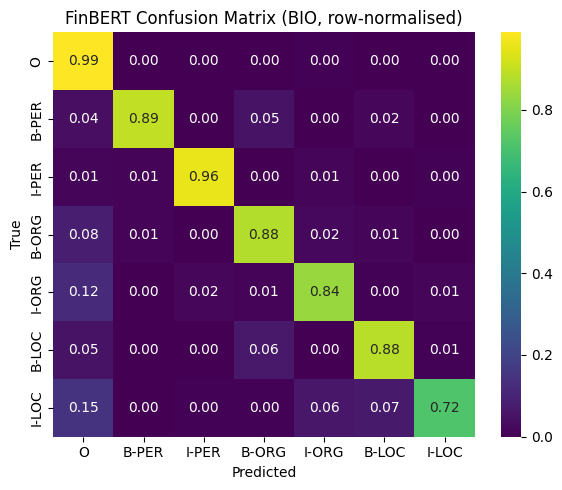

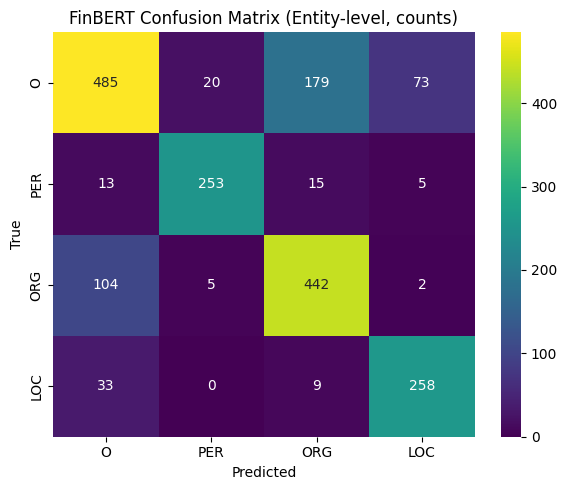

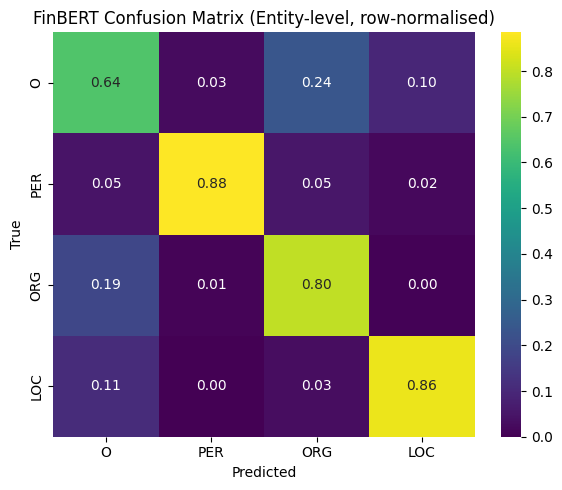

In [ ]:
# reconstruct BIO tags from the saved test predictions
labels = finbert_pred_out.label_ids
pred_ids = np.argmax(finbert_pred_out.predictions, axis=-1)

finbert_true_test, finbert_pred_test = [], []
for p_row, l_row in zip(pred_ids, labels):
    tt, pt = [], []
    for p_i, l_i in zip(p_row, l_row):
        if l_i == -100:
            continue
        tt.append(ID_TO_LABEL[l_i])
        pt.append(ID_TO_LABEL[p_i])
    finbert_true_test.append(tt)
    finbert_pred_test.append(pt)

print("FinBERT Test Classification Report:")
print(seq_classification_report(finbert_true_test, finbert_pred_test, digits=4))

# BIO-level, row-normalised
flat_true_bio = [t for seq in finbert_true_test for t in seq]
flat_pred_bio = [p for seq in finbert_pred_test for p in seq]

cm_bio_finbert = build_confusion(flat_true_bio, flat_pred_bio, BIO_LABELS, normalize="true")
show_cm(
    cm_bio_finbert,
    BIO_LABELS,
    "FinBERT Confusion Matrix (BIO, row-normalised)",
    os.path.join(save_dir, "finbert_cm_bio.png")
)

# Entity-level, counts
ent_pairs_finbert = pairs_for_confusion(finbert_true_test, finbert_pred_test, add_background=True)
ent_true_finbert = [a for (a, _) in ent_pairs_finbert]
ent_pred_finbert = [b for (_, b) in ent_pairs_finbert]

cm_ent_finbert = build_confusion(ent_true_finbert, ent_pred_finbert, ENT_LABELS, normalize=None)
show_cm(
    cm_ent_finbert,
    ENT_LABELS,
    "FinBERT Confusion Matrix (Entity-level, counts)",
    os.path.join(save_dir, "finbert_cm_entity_counts.png"),
    value_fmt=".0f"
)

# Entity-level, row-normalised
cm_ent_norm_finbert = build_confusion(ent_true_finbert, ent_pred_finbert, ENT_LABELS, normalize="true")
show_cm(
    cm_ent_norm_finbert,
    ENT_LABELS,
    "FinBERT Confusion Matrix (Entity-level, row-normalised)",
    os.path.join(save_dir, "finbert_cm_entity_norm.png")
)

### Misclassified Examples (on Test Set)

In [ ]:
# Use the saved predictions
print("Generating FinBERT span-level error reports...")
df_finbert_type, df_finbert_fn, df_finbert_fp = generate_span_error_report(
    finbert_true_test,
    finbert_pred_test,
    df_sent_test['gold_token'],
    df_sent_test.index
)

print(f"[FinBERT Type confusions] {len(df_finbert_type)}  |  [FN] {len(df_finbert_fn)}  |  [FP] {len(df_finbert_fp)}")

# Save and show head of type confusions
out_path = os.path.join(save_dir, "finbert_errors_type_confusions.csv")
df_finbert_type.to_csv(out_path, index=False)
print(f"Saved to {out_path}")
print("\n--- FinBERT Type Confusions (Head) ---")
print(df_finbert_type[["row_id","gold_type","pred_type","surface_gold","surface_pred"]].head(10).to_string(index=False))

Generating FinBERT span-level error reports...
[FinBERT Type confusions] 45  |  [FN] 84  |  [FP] 206
Saved to runs/finbert_finerord_ft/finbert_errors_type_confusions.csv

--- FinBERT Type Confusions (Head) ---
 row_id gold_type pred_type                       surface_gold                       surface_pred
     54       ORG       LOC                      government 's                         government
    386       ORG       LOC                             France                             France
    560       ORG       LOC                           Street )                                  )
    629       ORG       LOC Balboa Capital Celebrates National Balboa Capital Celebrates National
    813       ORG       LOC                          Dabanga .                                  .
     74       ORG       PER                20 , 2015 at 7:07PM                20 , 2015 at 7:07PM
    310       ORG       PER                       Ziosk is the                       Ziosk is the
    31

In [ ]:
# --- FinBERT Token-Level Error Report ---
print("Generating FinBERT token-level error report...")
df_finbert_token_errors = generate_token_error_report(
    finbert_true_test,
    finbert_pred_test,
    df_sent_test['gold_token'],
    df_sent_test['sentence'],
    df_sent_test.index
)

out_path = os.path.join(save_dir, "finbert_errors_token_level.csv")
df_finbert_token_errors.to_csv(out_path, index=False)
print(f"Saved FinBERT token-level misclassifications: {len(df_finbert_token_errors)} rows -> {out_path}")
print(df_finbert_token_errors.head(10).to_string())

Generating FinBERT token-level error report...
Saved FinBERT token-level misclassifications: 557 rows -> runs/finbert_finerord_ft/finbert_errors_token_level.csv
   row_id  original_df_index  token_index            left       token             right   gold   pred                                                                                                                                                                                                                                                                                                                                                                 sentence
0       0                 10            6       Hong Kong      public       - transport      O  I-ORG                                                                                                                                                                                                                                                             A woman on the Hong Ko

## Final Model Comparison

In [ ]:
# Create summary table from the metrics we saved in variables
summary = pd.DataFrame(
    {
        "Model":   ["spaCy (en_core_web_sm)", "FinBERT (fine-tuned)"],
        "Precision": [spacy_p, finbert_p],
        "Recall":    [spacy_r, finbert_r],
        "F1":        [spacy_f, finbert_f],
    }
).round(4)

print("\n====== Final Summary (TEST SET) ======")
print(summary.to_string(index=False))


====== Final Summary (TEST SET) ======
                 Model  Precision  Recall     F1
spaCy (en_core_web_sm)     0.5723  0.5838 0.5780
  FinBERT (fine-tuned)     0.7557  0.8367 0.7942


## Export FinBERT Run
If using google colab, this zips the entire FinBERT run directory for download

In [ ]:
# print(f"Zipping contents of {save_dir}...")
# zip_path = "/content/finbert_finerord_ft.zip"
#
# with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
#     for root, _, file_names in os.walk(save_dir):
#         for f in file_names:
#             full = os.path.join(root, f)
#             arc  = os.path.relpath(full, start=os.path.dirname(save_dir)) # Use parent dir for cleaner arcname
#             z.write(full, arc)
#
# print(f"Zip file created at {zip_path}")
# files.download(zip_path)

In [ ]:
# !zip -r finbert_finerord_ft.zip ../runs/finbert_finerord_ft
# from google.colab import files
# files.download("finbert_finerord_ft.zip")


In [ ]:
!ls /content/runs/finbert_finerord_ft


checkpoint-1020     finbert_cm_entity_counts.png	tokenizer_config.json
checkpoint-204	    finbert_cm_entity_norm.png		tokenizer.json
checkpoint-408	    finbert_errors_token_level.csv	training_args.bin
checkpoint-612	    finbert_errors_type_confusions.csv	val_metrics.json
checkpoint-816	    model.safetensors			vocab.txt
config.json	    special_tokens_map.json
finbert_cm_bio.png  test_metrics.json


In [ ]:
import os
print(os.getcwd())
!ls -R | head -20

/content
.:
ablation_results
drive
finbert_finerord_ft.zip
logs
runs
sample_data
tmp_model

./ablation_results:

./drive:
MyDrive

./drive/MyDrive:
2023 RNF BBQ Proposal.docx
2023 RNF BBQ Proposal Draft 1 w comments[2620].gdoc
2E5CD2E6-4A3F-4397-9A7F-7F44CEAB7432.jpeg
4ECB2B23-36E9-429B-BFAC-EEF455180D5A.png
Booking Confirmation_29061081236_1[3].pdf


In [ ]:
# Point to your run directory (make this ABSOLUTE and VALID in your runtime)
run_dir = os.path.abspath("/content/runs/finbert_finerord_ft")  # adjust if needed
assert os.path.isdir(run_dir), f"Not found: {run_dir}"

# Where to save the zip (put it in /content)
zip_path = "/content/finbert_finerord_ft.zip"

# Create zip with RELATIVE arc names (no '../' in zip)
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for root, _, file_names in os.walk(run_dir):
        for f in file_names:
            full = os.path.join(root, f)
            arc  = os.path.relpath(full, start=run_dir)  # relative path inside zip
            z.write(full, arc)

# Quick sanity checks (size + a few entries)
print("Zip size:")
subprocess.run(shlex.split(f"ls -lh {zip_path}"))
print("\nArchive listing (first 20 lines):")
subprocess.run(shlex.split(f"unzip -l {zip_path} | sed -n '1,20p'"))

# Download
from google.colab import files # Re-import files to ensure it's the correct module
files.download(zip_path)

Zip size:

Archive listing (first 20 lines):


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ablation Studies

Phase A (cheap, high signal)

Data size: train on 10%, 25%, 50%, 100% of train set

Freeze pretrained layers vs. full fine-tune (freeze encoder)

Remove CRITICAL label distinctions (merge B/I into single entity label; or collapse entity types into ENTITY)

Tokenizer effects: use do_lower_case variant / different max_length (128 vs 256)

Phase B (moderate cost)

Class-weighting / loss re-weighting for imbalanced classes

Remove warmup, change LR (2e-5 vs 5e-6 vs 5e-5)

Gradient accumulation / batch size effects (8 vs 16 vs 32 effective)

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig
from transformers import DataCollatorForTokenClassification, TrainingArguments, Trainer
import itertools
import pandas as pd
import os
import numpy as np

# Re-import seqeval and evaluate (already imported in previous cells but good for self-containment if this cell was run standalone)
import importlib
from seqeval.metrics import (f1_score as seq_f1,
                             precision_score as seq_precision,
                             recall_score as seq_recall)

# --- CONFIG ---
BASE_MODEL = os.path.abspath(os.path.join(RUN_DIR, "finbert_finerord_ft")) # Changed to use absolute path
OUTPUT_DIR = "ablation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TEXT_COL = "gold_token"   # list of tokens per sentence
LABEL_COL = "gold_label"  # list of native int labels per sentence

# --- HELPER FUNCTIONS FOR LABEL MAPPING (from xoh4wxN-k8iL and YPyNWCi_loMS) ---
ID2LAB_NATIVE = ["O", "PER_B", "PER_I", "LOC_B", "LOC_I", "ORG_B", "ORG_I"]

def ids_to_bio(id_list):
    out = []
    for x in id_list:
        t = ID2LAB_NATIVE[int(x)]
        if t.endswith("_B"):
            out.append("B-" + t[:-2])
        elif t.endswith("_I"):
            out.append("I-" + t[:-2])
        else:
            out.append(t)    # "O"
    return out

# Define BIO_LABELS and mappings for the model's output
BIO_LABELS = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]
label2id = {lab: i for i, lab in enumerate(BIO_LABELS)}
id2label = {i: lab for lab, i in label2id.items()}
num_labels = len(BIO_LABELS)

print(f"Detected {num_labels} labels: {BIO_LABELS}")

# --- TOKENIZER ---
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# Modified tokenize and align labels function
def tokenize_and_align_labels(examples, tokenizer, max_len=256):
    tokenized_inputs = tokenizer(
        examples[TEXT_COL],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=max_len
    )

    all_aligned_labels = []
    for i in range(len(examples[TEXT_COL])): # Iterate through each example (sentence) in the batch
        # gold_labels_for_sentence is a list of native integer labels for tokens in THIS sentence
        gold_labels_for_sentence_native = examples[LABEL_COL][i]

        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels_for_sentence = []
        previous_word_idx = None

        # Convert native integer labels to BIO string labels first for this sentence
        bio_tags_for_sentence = ids_to_bio(gold_labels_for_sentence_native)

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels_for_sentence.append(-100) # -100 is ignored by PyTorch loss
            elif word_idx != previous_word_idx: # First token of a new word
                # Use the BIO string tag and map to model's integer ID
                aligned_labels_for_sentence.append(label2id[bio_tags_for_sentence[word_idx]])
            else: # Subsequent subword token of the same word
                # For subword tokens, if the original word's tag was B-X, it becomes I-X
                current_bio_tag_str = bio_tags_for_sentence[word_idx]
                if current_bio_tag_str.startswith("B-"):
                    aligned_labels_for_sentence.append(label2id["I-" + current_bio_tag_str[2:]])
                else: # O or I-X, just use as is
                    aligned_labels_for_sentence.append(label2id[current_bio_tag_str])
            previous_word_idx = word_idx
        all_aligned_labels.append(aligned_labels_for_sentence)

    tokenized_inputs["labels"] = all_aligned_labels
    return tokenized_inputs

# --- USE ALREADY PREPARED SENTENCE-LEVEL DATASET (ds_sent) ---
# Ensure ds_sent is available by re-creating it from the pre-processed dataframes
ds_sent = DatasetDict({
    "train":      Dataset.from_pandas(df_sent_train),
    "validation": Dataset.from_pandas(df_sent_val),
    "test":       Dataset.from_pandas(df_sent_test),
})

tokenized_datasets = ds_sent.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer, max_len=256),
    batched=True,
    remove_columns=ds_sent["train"].column_names,
)
tokenized_datasets.set_format("torch")

# --- METRICS (Using seqeval for NER specific metrics) ---
seqeval_metric = importlib.import_module("evaluate").load("seqeval")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    true_tags, pred_tags = [], []
    for p_row, l_row in zip(preds, labels):
        t_seq, p_seq = [], []
        for p_i, l_i in zip(p_row, l_row):
            if l_i == -100: continue
            t_seq.append(id2label[l_i]); p_seq.append(id2label[p_i])
        true_tags.append(t_seq); pred_tags.append(p_seq)
    res = seqeval_metric.compute(predictions=pred_tags, references=true_tags)
    return {"precision": res["overall_precision"],
            "recall":    res["overall_recall"],
            "f1":        res["overall_f1"],
            "accuracy":  res["overall_accuracy"]}

# ----------------------------
# ABLATION GRID
# ----------------------------
grid = {
    "learning_rate": [5e-5, 3e-5],
    "batch_size": [8, 16],
    "dropout": [0.1, 0.3],
    "freeze_encoder": [True, False],
}
param_combinations = list(itertools.product(*grid.values()))
columns = list(grid.keys())
results = []

# ----------------------------
# RUN ABLATION
# ----------------------------
for i, params in enumerate(param_combinations):
    config = dict(zip(columns, params))
    print(f"\n===== Running config {i+1}/{len(param_combinations)} ===[ablation]=====")
    print(config)

    model_config = AutoConfig.from_pretrained(
        BASE_MODEL,
        num_labels=num_labels,
        hidden_dropout_prob=config["dropout"],
        attention_probs_dropout_prob=config["dropout"],
        id2label=id2label,
        label2id=label2id
    )

    model = AutoModelForTokenClassification.from_pretrained(
        BASE_MODEL,
        config=model_config,
        ignore_mismatched_sizes=True
    )

    # Freeze encoder
    if config["freeze_encoder"]:
        if hasattr(model, "bert"):
            for p in model.bert.parameters(): p.requires_grad = False
        elif hasattr(model, "roberta"):
            for p in model.roberta.parameters(): p.requires_grad = False

    # Data collator
    data_collator = DataCollatorForTokenClassification(tokenizer)

    training_args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/run_{i}",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=3,
        eval_strategy="epoch", # Changed from evaluation_strategy to eval_strategy
        save_strategy="no",
        logging_dir=f"{OUTPUT_DIR}/logs",
        seed=42,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()
    metrics.update(config)
    results.append(metrics)

# ----------------------------
# SAVE RESULTS
# ----------------------------
df = pd.DataFrame(results)
csv_path = os.path.join(save_path, "phaseA_results.csv")  # Save to Drive folder
df.to_csv(csv_path, index=False)
print(f"\n✅ Ablation complete! Results saved to {csv_path}")

Detected 7 labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


Map:   0%|          | 0/3262 [00:00<?, ? examples/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]


===== Running config 1/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 8, 'dropout': 0.1, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.084861,0.830400,0.852217,0.841167,0.980382
2,0.011300,0.086429,0.831731,0.852217,0.841849,0.980297
3,0.010900,0.086761,0.831731,0.852217,0.841849,0.980297



===== Running config 2/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 8, 'dropout': 0.1, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.106991,0.801587,0.829228,0.815174,0.977155
2,0.029200,0.095958,0.825291,0.814450,0.819835,0.975796
3,0.015600,0.096038,0.839806,0.852217,0.845966,0.978429



===== Running config 3/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 8, 'dropout': 0.3, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.085488,0.805513,0.863711,0.833597,0.978769
2,0.068000,0.089173,0.802131,0.865353,0.832543,0.978174
3,0.067200,0.090225,0.802131,0.865353,0.832543,0.978174



===== Running config 4/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 8, 'dropout': 0.3, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.119152,0.789720,0.832512,0.810552,0.975966
2,0.053800,0.114980,0.832248,0.839080,0.835650,0.977580
3,0.033900,0.110966,0.842190,0.858785,0.850407,0.978938



===== Running config 5/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': 0.1, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.084139,0.830400,0.852217,0.841167,0.980212
2,No log,0.085521,0.831731,0.852217,0.841849,0.980127
3,0.011800,0.085898,0.834405,0.852217,0.843217,0.980212



===== Running config 6/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': 0.1, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.101907,0.787200,0.807882,0.797407,0.973503
2,No log,0.094677,0.832226,0.822660,0.827415,0.976730
3,0.019200,0.100043,0.852700,0.855501,0.854098,0.978089



===== Running config 7/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': 0.3, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.083067,0.806748,0.863711,0.834259,0.978769
2,No log,0.086071,0.803354,0.865353,0.833202,0.978514
3,0.068300,0.086810,0.801829,0.863711,0.831621,0.978514



===== Running config 8/16 ===[ablation]=====
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': 0.3, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.091948,0.802469,0.853859,0.827367,0.977155
2,No log,0.096101,0.816327,0.853859,0.834671,0.978769
3,0.040700,0.100242,0.829921,0.865353,0.847267,0.979618



===== Running config 9/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 8, 'dropout': 0.1, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.083661,0.831731,0.852217,0.841849,0.980297
2,0.011400,0.084867,0.831731,0.852217,0.841849,0.980297
3,0.011000,0.085190,0.831731,0.852217,0.841849,0.980297



===== Running config 10/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 8, 'dropout': 0.1, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.111333,0.831148,0.832512,0.831829,0.977070
2,0.022600,0.094947,0.832512,0.832512,0.832512,0.979533
3,0.011900,0.092362,0.853181,0.858785,0.855974,0.980042



===== Running config 11/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 8, 'dropout': 0.3, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.082504,0.807396,0.860427,0.833068,0.978599
2,0.070300,0.085281,0.803053,0.863711,0.832278,0.978599
3,0.069400,0.086103,0.801829,0.863711,0.831621,0.978514



===== Running config 12/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 8, 'dropout': 0.3, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.113115,0.800312,0.842365,0.820800,0.977240
2,0.047500,0.115278,0.819646,0.835796,0.827642,0.976476
3,0.032900,0.105666,0.822504,0.852217,0.837097,0.978938



===== Running config 13/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 16, 'dropout': 0.1, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.083127,0.830400,0.852217,0.841167,0.980382
2,No log,0.084153,0.833066,0.852217,0.842532,0.980212
3,0.011900,0.084475,0.831731,0.852217,0.841849,0.980127



===== Running config 14/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 16, 'dropout': 0.1, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.093016,0.809221,0.835796,0.822294,0.977834
2,No log,0.091512,0.841322,0.835796,0.838550,0.978429
3,0.015400,0.091973,0.849026,0.858785,0.853878,0.979788



===== Running config 15/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 16, 'dropout': 0.3, 'freeze_encoder': True}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.080858,0.809598,0.858785,0.833466,0.978684
2,No log,0.082791,0.805215,0.862069,0.832672,0.978769
3,0.070700,0.083383,0.806748,0.863711,0.834259,0.978769



===== Running config 16/16 ===[ablation]=====
{'learning_rate': 3e-05, 'batch_size': 16, 'dropout': 0.3, 'freeze_encoder': False}


/tmp/ipython-input-1965040844.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.094245,0.810769,0.865353,0.837172,0.976815
2,No log,0.095143,0.812693,0.862069,0.836653,0.979278
3,0.040200,0.096833,0.820755,0.857143,0.838554,0.979363



✅ Ablation complete! Results saved to /content/drive/MyDrive/Group_Project_Results/phaseA_results.csv


In [ ]:
print(ds_sent)
print(ds_sent["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 3262
    })
    validation: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 402
    })
    test: Dataset({
        features: ['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets'],
        num_rows: 1075
    })
})
['doc_idx', 'sent_idx', 'gold_token', 'gold_label', 'gold_tag', 'sentence', 'offsets']


In [ ]:
# ablation_phaseB.py
# Data and tokenization ablation for FinBERT NER

import os
import random
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import DatasetDict
import torch
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# CONFIG
# BASE_MODEL should be the finbert_finerord_ft directory from Phase A
BASE_MODEL = os.path.join(RUN_DIR, "finbert_finerord_ft") # Corrected to local path
TOKENIZER_VARIANTS = [
    "ProsusAI/finbert",              # using a working public tokenizer
]
DATA_PATH = "data/fiqa_ner" # This path is not directly used for dataset loading now
OUTPUT_DIR = "ablation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# LOAD DATA
# Use BIO_LABELS from global scope, as this is for NER
label_list = BIO_LABELS
num_labels = len(label_list)

# UTILITY: Add label noise
def add_label_noise(examples, noise_rate, num_labels):
    """Randomly flips a fraction of labels in-place for gold_label (native int)."""
    # gold_label in ds_sent are native int IDs
    new_labels = []
    for tags_int in examples["gold_label"]:
        tags = np.array(tags_int) # convert to numpy for masking
        mask = np.random.rand(len(tags)) < noise_rate
        # Random labels should be within the range of native integer labels (0 to len(ID2LAB_NATIVE) - 1)
        rand_labels = np.random.randint(0, len(ID2LAB_NATIVE), size=len(tags))
        tags[mask] = rand_labels[mask]
        new_labels.append(tags.tolist())
    examples["gold_label"] = new_labels
    return examples

# TOKENIZE + ALIGN (adapted for ds_sent features)
def tokenize_and_align_labels(example, tokenizer):
    tokenized_inputs = tokenizer(
        example["gold_token"], is_split_into_words=True,
        truncation=True
    )
    labels = []
    for i in range(len(example["gold_token"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None

        # Convert native integer gold_label to BIO string labels for alignment
        bio_tags_for_sentence = finer_ids_to_bio(example["gold_label"][i])

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                aligned_labels.append(LABEL_TO_ID[bio_tags_for_sentence[word_idx]])
            else: # Subsequent subword token of the same word
                current_bio_tag_str = bio_tags_for_sentence[word_idx]
                if current_bio_tag_str.startswith("B-"):
                    aligned_labels.append(LABEL_TO_ID["I-" + current_bio_tag_str[2:]])
                else:
                    aligned_labels.append(LABEL_TO_ID[current_bio_tag_str])
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# GRID CONFIGS
grid = {
    "data_fraction": [1.0, 0.5, 0.25],
    "label_noise": [0.0, 0.05, 0.1],
    "tokenizer_name": TOKENIZER_VARIANTS,
}

import itertools
param_combinations = list(itertools.product(*grid.values()))
columns = list(grid.keys())

results = []

# METRIC FUNCTION
def compute_metrics(eval_pred):
    # Reusing the compute_metrics from the previous FinBERT NER cell (_Yg8Dqpt9aCw)
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    true_tags, pred_tags = [], []
    for p_row, l_row in zip(preds, labels):
        t_seq, p_seq = [], []
        for p_i, l_i in zip(p_row, l_row):
            if l_i == -100: continue
            t_seq.append(id2label[l_i]); p_seq.append(id2label[p_i])
        true_tags.append(t_seq); pred_tags.append(p_seq)
    res = seqeval_metric.compute(predictions=pred_tags, references=true_tags)
    return {"precision": res["overall_precision"],
            "recall":    res["overall_recall"],
            "f1":        res["overall_f1"],
            "accuracy":  res["overall_accuracy"]}

# MAIN LOOP
for i, params in enumerate(param_combinations):
    cfg = dict(zip(columns, params))
    print(f"\n===== Running Phase B config {i+1}/{len(param_combinations)} ====")
    print(cfg)

    # 1‶ Subsample dataset
    if cfg["data_fraction"] < 1.0:
        train_sample = ds_sent["train"].shuffle(seed=SEED).select(
            range(int(cfg["data_fraction"] * len(ds_sent["train"])))
        )
    else:
        train_sample = ds_sent["train"]

    # 2‶ Inject label noise
    if cfg["label_noise"] > 0.0:
        noisy_train = train_sample.map(
            lambda x: add_label_noise(x, cfg["label_noise"], num_labels),
            batched=True
        )
    else:
        noisy_train = train_sample

    # 3‶ Tokenizer setup
    tokenizer = AutoTokenizer.from_pretrained(cfg["tokenizer_name"])
    tokenized_train = noisy_train.map(
        lambda x: tokenize_and_align_labels(x, tokenizer), batched=True,
        remove_columns=ds_sent["train"].column_names # Remove original columns after tokenization
    )
    tokenized_eval = ds_sent["validation"].map(
        lambda x: tokenize_and_align_labels(x, tokenizer), batched=True,
        remove_columns=ds_sent["validation"].column_names # Remove original columns after tokenization
    )

    # Set format for PyTorch
    tokenized_train.set_format("torch")
    tokenized_eval.set_format("torch")

    # 4‶ Model + Trainer
    model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL, num_labels=num_labels)
    data_collator = DataCollatorForTokenClassification(tokenizer)

    training_args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/phaseB_run_{i}",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        eval_strategy="epoch", # Use eval_strategy for newer transformers versions
        save_strategy="no",
        logging_dir=f"{OUTPUT_DIR}/logsB",
        report_to="none",
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    preds_output = trainer.predict(tokenized_eval)
    metrics = compute_metrics(preds_output)
    metrics.update(cfg)
    results.append(metrics)

# SAVE RESULTS
df = pd.DataFrame(results)
csv_path = os.path.join(save_path, "phaseB_results.csv")  # Save directly to Drive
df.to_csv(csv_path, index=False)
print(f"\n✅ Phase B ablation complete! Results saved to {csv_path}")


===== Running Phase B config 1/9 ====
{'data_fraction': 1.0, 'label_noise': 0.0, 'tokenizer_name': 'ProsusAI/finbert'}


Map:   0%|          | 0/3262 [00:00<?, ? examples/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

/tmp/ipython-input-1835292051.py:172: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


# Sentence-Based Sentiment Analysis (SBSA)

In [ ]:
# Load FiQA dataset
ds_fiqa = load_dataset("TheFinAI/fiqa-sentiment-classification")

# Tokenization
def tokenize_function(example, tokenizer):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128)

# Add 'labels' for regression
def add_labels(example):
    example["labels"] = float(example["score"])
    return example

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metrics for regression
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.squeeze()
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    return {"mse": mse, "rmse": rmse}

# Training arguments
training_args = TrainingArguments(
    output_dir="./tmp_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    do_train=True,
    do_eval=True
)




## Baseline 1: FinBERT

In [ ]:
# Load tokenizers and tokenize datasets
tokenizer_finbert = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
tokenized_finbert = ds_fiqa.map(lambda x: tokenize_function(x, tokenizer_finbert), batched=True)
tokenized_finbert = tokenized_finbert.map(add_labels)

# Prepare DatasetDict
dataset_finbert = DatasetDict({
    "train": tokenized_finbert["train"],
    "validation": tokenized_finbert["valid"],
    "test": tokenized_finbert["test"]
})

# Load models for regression
model_finbert = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=1,
    ignore_mismatched_sizes=True
)
model_finbert.config.problem_type = "regression"
model_finbert.to(device)

# Trainer
trainer_finbert = Trainer(
    model=model_finbert,
    args=training_args,
    train_dataset=dataset_finbert["train"],
    eval_dataset=dataset_finbert["validation"],
    tokenizer=tokenizer_finbert,
    compute_metrics=compute_metrics
)

# Train model
print("Training FinBERT...")
trainer_finbert.train()

## Baseline 2: RoBERTa

In [ ]:
ds_fiqa = load_dataset("TheFinAI/fiqa-sentiment-classification")

# Tokenization
def tokenize_function(example, tokenizer):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128)

# Add 'labels' for regression
def add_labels(example):
    example["labels"] = float(example["score"])
    return example


# Load tokenizers and tokenize datasets
tokenizer_roberta = AutoTokenizer.from_pretrained("soleimanian/financial-roberta-large-sentiment")
tokenized_roberta = ds_fiqa.map(lambda x: tokenize_function(x, tokenizer_roberta), batched=True)
tokenized_roberta = tokenized_roberta.map(add_labels)

# Prepare DatasetDict
dataset_roberta = DatasetDict({
    "train": tokenized_roberta["train"],
    "validation": tokenized_roberta["valid"],
    "test": tokenized_roberta["test"]
})


# Load models for regression
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    "soleimanian/financial-roberta-large-sentiment",
    num_labels=1,
    ignore_mismatched_sizes=True
)
model_roberta.config.problem_type = "regression"
model_roberta.to(device)

# Trainer
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args,
    train_dataset=dataset_roberta["train"],
    eval_dataset=dataset_roberta["validation"],
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics
)

# Train model
print("Training Financial RoBERTa...")
trainer_roberta.train()

# Save the model & tokenizer
save_dir = os.path.join(RUN_DIR, "roberta_fiqa_ft") # Corrected path to use RUN_DIR
os.makedirs(save_dir, exist_ok=True)

trainer_roberta.save_model(save_dir)
tokenizer_roberta.save_pretrained(save_dir)

print(f"Model and tokenizer saved to {save_dir}")

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at soleimanian/financial-roberta-large-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3387861257.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


Training Financial RoBERTa...


Step,Training Loss
50,0.219400
100,0.174700
150,0.089700
200,0.107000
250,0.084500
300,0.087200
350,0.098200
400,0.094900
450,0.069600
500,0.066300


Model and tokenizer saved to runs/roberta_fiqa_ft


## Evaluation

In [ ]:
# Example financial sentences for evaluation
test_sentences = [
    "The company's quarterly earnings exceeded analyst expectations.",
    "Investors remain cautious as inflation rates continue to rise.",
    "The stock plummeted after the CEO announced his resignation.",
    "Revenue growth slowed compared to last year’s strong performance.",
    "Market sentiment improved following the release of the latest GDP data.",
    "The central bank’s decision to hold interest rates steady surprised traders.",
    "The startup secured a major funding round from international investors.",
    "Weak consumer demand led to disappointing sales figures.",
    "Oil prices stabilized after weeks of volatility.",
    "The company’s new product launch received mixed reviews from the market."
]

def predict_sentiment(model, tokenizer, sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.squeeze().cpu().numpy()
    return preds

finbert_scores = predict_sentiment(model_finbert, tokenizer_finbert, test_sentences)
roberta_scores = predict_sentiment(model_roberta, tokenizer_roberta, test_sentences)

import pandas as pd

results_df = pd.DataFrame({
    "Sentence": test_sentences,
    "FinBERT_Score": finbert_scores,
    "RoBERTa_Score": roberta_scores
})

# Sort by RoBERTa score (optional)
results_df = results_df.sort_values(by="RoBERTa_Score", ascending=False)

print(results_df.round(3))



## Comparison (Scatter Plot)

In [ ]:
# Predict on test set
def get_test_predictions(trainer, dataset):
    preds = trainer.predict(dataset)
    return preds.predictions.squeeze()

y_true = np.array(dataset_finbert["test"]["labels"])
y_pred_finbert = get_test_predictions(trainer_finbert, dataset_finbert["test"])
y_pred_roberta = get_test_predictions(trainer_roberta, dataset_roberta["test"])

# Scatter plot: Predicted vs True
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_finbert, color='blue', alpha=0.6, label='FinBERT')
plt.scatter(y_true, y_pred_roberta, color='red', alpha=0.6, label='RoBERTa')
plt.plot([-1, 1], [-1, 1], color='black', linestyle='--')
plt.xlabel("True Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Predicted vs True Sentiment Scores")
plt.legend()
plt.show()


## Ablation Studies

In [ ]:
# Helpers
def tokenize_function(example, tokenizer, max_length=128):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

def add_labels(example):
    example["labels"] = float(example["score"])
    return example

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.squeeze()
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    return {"mse": mse, "rmse": rmse}

# Freeze layers util
def freeze_layers(model, num_unfrozen_layers=0):
    try:
        encoder_layers = model.base_model.encoder.layer
    except AttributeError:
        encoder_layers = model.roberta.encoder.layer
    total = len(encoder_layers)
    for i, layer in enumerate(encoder_layers):
        requires = i >= (total - num_unfrozen_layers)
        for p in layer.parameters():
            p.requires_grad = requires
    print(f"✅ Unfroze last {num_unfrozen_layers}/{total} layers")

# Custom Trainer for different losses
class CustomLossTrainer(Trainer):
    def __init__(self, *args, loss_type="mse", **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Accepts extra kwargs (like num_items_in_batch) from Trainer.train()
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        preds = outputs.logits.squeeze()

        if self.loss_type == "mse":
            loss = F.mse_loss(preds, labels)
        elif self.loss_type == "mae":
            loss = F.l1_loss(preds, labels)
        elif self.loss_type == "huber":
            loss = F.huber_loss(preds, labels, delta=1.0)
        else:
            raise ValueError(f"Unknown loss type: {self.loss_type}")

        return (loss, outputs) if return_outputs else loss


# Training args
training_args = TrainingArguments(
    output_dir="./tmp_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    num_train_epochs=2,  # shorten for ablation
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=0, # Changed from 1 to 0 to prevent saving models during ablation
    do_train=True,
    do_eval=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment configs
model_name = "soleimanian/financial-roberta-large-sentiment"
freeze_options = [0, 2]               # freeze all, last2, full fine-tune
max_lengths = [64, 128, 256]
loss_types = ["mse", "mae", "huber"]
label_scaling = [False, True]

# Prepare results container
results = []

# Main loops
for freeze_num in freeze_options:
    for max_len in max_lengths:
        for loss_type in loss_types:
            for scale in label_scaling:

                print("="*80)
                print(f"Freeze={freeze_num}, MaxLen={max_len}, Loss={loss_type}, Scaled={scale}")
                print("="*80)

                # --- Load tokenizer & tokenize ---
                tokenizer = AutoTokenizer.from_pretrained(model_name)
                tokenized = ds_fiqa.map(lambda x: tokenize_function(x, tokenizer, max_len), batched=True)

                # --- Label scaling ---
                if scale:
                    train_scores = np.array(tokenized["train"]["score"])
                    mean, std = train_scores.mean(), train_scores.std()
                    def add_scaled_labels(ex):
                        ex["labels"] = (ex["score"] - mean) / std
                        return ex
                    tokenized = tokenized.map(add_scaled_labels)
                else:
                    tokenized = tokenized.map(add_labels)

                dataset = DatasetDict({
                    "train": tokenized["train"],
                    "validation": tokenized["valid"],
                    "test": tokenized["test"]
                })

                # --- Load model ---
                model = AutoModelForSequenceClassification.from_pretrained(
                    model_name, num_labels=1, ignore_mismatched_sizes=True
                )
                model.config.problem_type = "regression"
                freeze_layers(model, num_unfrozen_layers=freeze_num)
                model.to(device)

                # --- Trainer ---
                trainer = CustomLossTrainer(
                    model=model,
                    args=copy.deepcopy(training_args),
                    train_dataset=dataset["train"],
                    eval_dataset=dataset["validation"],
                    tokenizer=tokenizer,
                    compute_metrics=compute_metrics,
                    loss_type=loss_type
                )
                trainer.args.output_dir = f"./runs/freeze{freeze_num}_len{max_len}_{loss_type}_{'scaled' if scale else 'raw'}"
                os.makedirs(trainer.args.output_dir, exist_ok=True)

                # --- Train & Eval ---
                trainer.train()
                eval_result = trainer.evaluate(dataset["validation"])

                results.append({
                    "freeze_layers": freeze_num,
                    "max_len": max_len,
                    "loss": loss_type,
                    "label_scaled": scale,
                    "val_mse": eval_result["eval_mse"],
                    "val_rmse": eval_result["eval_rmse"]
                })

                # save intermediate results
                pd.DataFrame(results).to_csv("results_ablation.csv", index=False)

# Summary
df = pd.DataFrame(results)
print("\n=== FINAL RESULTS ===")
print(df.sort_values("val_rmse"))

Freeze=0, MaxLen=64, Loss=mse, Scaled=False


Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at soleimanian/financial-roberta-large-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Unfroze last 0/24 layers


/tmp/ipython-input-2639183330.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss


KeyboardInterrupt: 

# Event Construction pipeline

In [ ]:
import torch
from transformers import pipeline, AutoModelForTokenClassification, AutoModelForSequenceClassification, AutoTokenizer
import os # Import os module for path manipulation

# Redefine RUN_DIR and create it if not already present
RUN_DIR = "runs"
os.makedirs(RUN_DIR, exist_ok=True)

# 1. Load models

# Construct absolute paths using RUN_DIR
NER_MODEL_DIR = os.path.abspath(os.path.join(RUN_DIR, "finbert_finerord_ft"))      # fine-tuned FinBERT NER
SENT_MODEL_DIR = os.path.abspath(os.path.join(RUN_DIR, "roberta_fiqa_ft"))  # FinRoBERTa sentiment

device = 0 if torch.cuda.is_available() else -1

# Explicitly load model and tokenizer objects first
ner_tokenizer = AutoTokenizer.from_pretrained(NER_MODEL_DIR)
ner_model = AutoModelForTokenClassification.from_pretrained(NER_MODEL_DIR)

sent_tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL_DIR)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL_DIR)


ner_pipe = pipeline(
    "ner",
    model=ner_model,
    tokenizer=ner_tokenizer,
    aggregation_strategy="simple",
    device=device
)

sent_pipe = pipeline(
    "text-classification",
    model=sent_model,
    tokenizer=sent_tokenizer,
    top_k=None,
    device=device
)

Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# 2. Preprocessing helper

def preprocess(text: str):
    """Basic text cleaning for financial headlines."""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"([.,!?])(?=[^\s])", r"\1 ", text)  # add space after punctuation
    return text.strip()

In [ ]:
import re, json, pandas as pd

# 3. Improved Event Construction (rule-based + synthesis)

# Define prioritized trigger rulebook
RULEBOOK = [
    (re.compile(r'\b(beats|exceeds|outperform)s?\b', re.I), "Earnings/Results", 1.0),
    (re.compile(r'\b(acquir|merg|buy|takeover|purchase)\b', re.I), "M&A", 1.0),
    (re.compile(r'\b(fund(ing)?|raises|invests)\b', re.I), "Funding", 0.9),
    (re.compile(r'\b(announc|launch|introduc|file)\b', re.I), "Product/Launch", 0.8),
    (re.compile(r'\b(upgrade|downgrade|cuts?)\b', re.I), "Rating/Guidance", 0.8),
    (re.compile(r'\b(layoff|restructur|redundanc(y|ies))\b', re.I), "Restructuring/HR", 0.7),
    (re.compile(r'\b(bankruptcy|insolvenc(y|ies)|liquidat)\b', re.I), "Financial Distress", 0.7)
]


def select_trigger(text):
    """Return best-matching trigger and event type."""
    for pattern, label, conf in RULEBOOK:
        if pattern.search(text):
            return {"text": pattern.pattern, "event_type": label, "trigger_conf": conf}
    return None


def construct_event_type(text, sent_score):
    """Infer event type using rulebook; fall back to sentiment-driven logic."""
    match = select_trigger(text)

    # 1️⃣ Trigger found
    if match:
        event_type = match["event_type"]
        trigger_text = match["text"]
        trig_conf = match["trigger_conf"]

    # 2️⃣ Sentiment-driven fallback
    elif abs(sent_score) > 0.6:
        event_type = "SentimentDriven"
        trigger_text = "sentiment_based"
        trig_conf = 0.4

    # 3️⃣ No rule or sentiment match
    else:
        event_type = "General/Unclassified"
        trigger_text = "none"
        trig_conf = 0.2

    return event_type, trigger_text, trig_conf


def compute_confidence(c_ner, c_trigger, sent_uncertainty):
    """Weighted aggregation of component confidences."""
    c_sent = 1 - sent_uncertainty
    return round(0.6 * c_trigger + 0.3 * c_ner + 0.1 * c_sent, 3)


# 4. Main analysis pipeline (updated)

def analyze_headline(headline: str):
    clean_text = preprocess(headline)

    # --- NER ---
    ner_results = ner_pipe(clean_text)
    entities = [
        {
            "text": ent["word"],
            "label": ent.get("entity_group", ent.get("entity")),
            "score": round(float(ent["score"]), 4),
            "start": int(ent["start"]),
            "end": int(ent["end"])
        }
        for ent in ner_results
    ]
    c_ner = max((e["score"] for e in entities), default=0.2)

    # --- Sentiment ---
    sent_result = sent_pipe(clean_text)[0][0] # Added [0] here
    sentiment_score = sent_result["score"] if "score" in sent_result else 0.0
    sentiment_label = sent_result["label"]
    # Approximate uncertainty: 1 - score if not provided
    sent_uncertainty = 1 - sentiment_score if sentiment_score <= 1 else 0.5

    sentiment = {
        "label": sentiment_label,
        "score": round(float(sentiment_score), 4),
        "uncertainty": round(float(sent_uncertainty), 4)
    }

    # --- Event type and trigger ---
    event_type, trigger_text, trig_conf = construct_event_type(clean_text, sentiment["score"])

    # --- Aggregate confidence ---
    event_conf = compute_confidence(c_ner, trig_conf, sentiment["uncertainty"])

    # --- Structured output ---
    result = {
        "headline": clean_text,
        "entities": entities,
        "sentiment": sentiment,
        "event_type": event_type,
        "trigger": {"text": trigger_text, "confidence": trig_conf},
        "confidence": event_conf
    }

    return result

In [ ]:
def analyze_batch(headlines, output_path=None, summary=True):
    """
    Analyze a list of financial headlines or a CSV file.
    Produces structured JSON events with triggers, sentiments, and confidence.
    Optionally writes results to a JSONL file or CSV file.
    """

    # --- Input handling ---
    if isinstance(headlines, str) and os.path.isfile(headlines):
        df = pd.read_csv(headlines)
        if "headline" not in df.columns:
            raise ValueError("CSV must contain a column named 'headline'.")
        headlines = df["headline"].dropna().tolist()

    # --- Run event extraction ---
    results = [analyze_headline(h) for h in headlines]

    # --- Save to file if requested ---
    if output_path:
        ext = os.path.splitext(output_path)[1].lower()
        if ext == ".jsonl":
            with open(output_path, "w", encoding="utf-8") as f:
                for r in results:
                    f.write(json.dumps(r, ensure_ascii=False) + "\n")
            print(f"✅ Saved {len(results)} results to {output_path}")
        elif ext == ".csv":
            # Flatten some nested fields for easier CSV export
            flat_rows = []
            for r in results:
                flat_rows.append({
                    "headline": r["headline"],
                    "event_type": r["event_type"],
                    "trigger": r["trigger"]["text"],
                    "sentiment_label": r["sentiment"]["label"],
                    "sentiment_score": r["sentiment"]["score"],
                    "confidence": r["confidence"],
                    "num_entities": len(r["entities"])
                })
            pd.DataFrame(flat_rows).to_csv(output_path, index=False)
            print(f"✅ Saved summarized results to {output_path}")
        else:
            raise ValueError("Output file must end with .jsonl or .csv")

    # --- Optional summary report ---
    if summary:
        df = pd.DataFrame(results)
        type_counts = df["event_type"].value_counts()
        avg_conf = df["confidence"].mean()
        print("\n📊 Summary:")
        print(f"Total headlines processed: {len(results)}")
        print(f"Average confidence: {avg_conf:.3f}")
        print("Top event types:")
        for etype, count in type_counts.head(5).items():
            print(f"  • {etype}: {count}")

    return results

In [ ]:
# 5. Example usage

if __name__ == "__main__":
    # Example 1: single headline
    headline = "Tesla acquires German battery startup to boost EV production"
    single = analyze_headline(headline)
    print(json.dumps(single, indent=2))

    # Example 2: batch from list
    headlines_list = [
        "Apple reports record quarterly earnings amid global demand surge",
        "JP Morgan fined $200 million over compliance failures",
        "Pfizer appoints new CEO following leadership reshuffle"
    ]
    batch_results = analyze_batch(headlines_list, output_path="event_outputs.jsonl")
    print("\nSample batch output (first item):")
    print(json.dumps(batch_results[0], indent=2))


# Example output

# {"headline": "Apple reports record quarterly earnings amid global demand surge", "entities": [{"text": "Apple", "label": "ORG", "score": 0.9987}], "sentiment": {"label": "positive", "score": 0.9612}, "event_type": "Earnings Release"}
# {"headline": "JP Morgan fined $200 million over compliance failures", "entities": [{"text": "JP Morgan", "label": "ORG", "score": 0.9945}], "sentiment": {"label": "negative", "score": 0.8871}, "event_type": "Legal/Regulatory"}
# {"headline": "Pfizer appoints new CEO following leadership reshuffle", "entities": [{"text": "Pfizer", "label": "ORG", "score": 0.9978}], "sentiment": {"label": "neutral", "score": 0.7512}, "event_type": "Leadership Change"}


{
  "headline": "Tesla acquires German battery startup to boost EV production",
  "entities": [
    {
      "text": "tesla",
      "label": "ORG",
      "score": 0.9882,
      "start": 0,
      "end": 5
    }
  ],
  "sentiment": {
    "label": "LABEL_0",
    "score": 0.4595,
    "uncertainty": 0.5405
  },
  "event_type": "General/Unclassified",
  "trigger": {
    "text": "none",
    "confidence": 0.2
  },
  "confidence": 0.462
}
✅ Saved 3 results to event_outputs.jsonl

📊 Summary:
Total headlines processed: 3
Average confidence: 0.462
Top event types:
  • General/Unclassified: 2
  • SentimentDriven: 1

Sample batch output (first item):
{
  "headline": "Apple reports record quarterly earnings amid global demand surge",
  "entities": [
    {
      "text": "apple",
      "label": "ORG",
      "score": 0.9934,
      "start": 0,
      "end": 5
    }
  ],
  "sentiment": {
    "label": "LABEL_0",
    "score": 0.6252,
    "uncertainty": 0.3748
  },
  "event_type": "SentimentDriven",
  "trigger